<a href="https://colab.research.google.com/github/Uditsingh7/Deep_Learning_Projects/blob/main/Udit_Audio_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Skipping, found downloaded files in "./quran-recitations-for-audio-classification" (use force=True to force download)


In [15]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import librosa # Library that is used to read and process audio files
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory
import time # Used to calculate time for each epoch or any processing time in seconds
from skimage.transform import resize # Used to resize the images and we will use it to resize audio waves

# detect the GPU if any, if not use CPU, change "cuda" to "mps" if you have a mac
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
# @title 3. Data

data_df = pd.read_csv("/content/quran-recitations-for-audio-classification/files_paths.csv") # Read the original csv as a dataframe

data_df['FilePath'] = '/content/quran-recitations-for-audio-classification/Dataset/' + data_df['FilePath'].str[1:] # Modify the paths in the dataframe


data_df.tail() # Visualize the first 5 rows

,FilePath,Class
6682,/content/quran-recitations-for-audio-classific...,Abdullah_Albuaijan
6683,/content/quran-recitations-for-audio-classific...,Abdullah_Albuaijan
6684,/content/quran-recitations-for-audio-classific...,Abdullah_Albuaijan
6685,/content/quran-recitations-for-audio-classific...,Abdullah_Albuaijan
6686,/content/quran-recitations-for-audio-classific...,Abdullah_Albuaijan


Data Shape is:  (6687, 2)


Claases Distrubution is: 


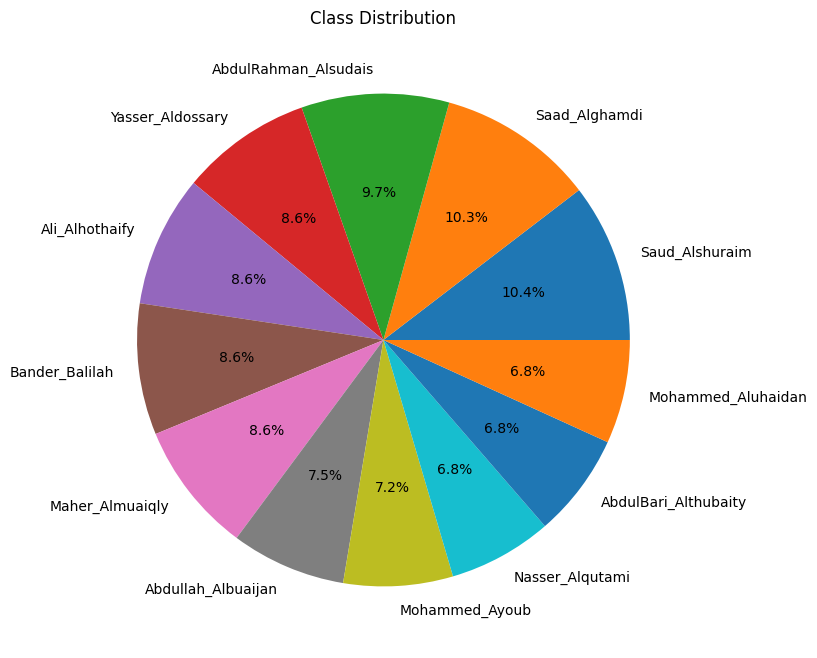

In [17]:
# @title 4. Data investigation

print("Data Shape is: ", data_df.shape) # Print the data shape (rows, columns)
print() # Empty line for better viewing

print() # Empty line for better viewing
print("Claases Distrubution is: ")

class_counts = data_df['Class'].value_counts() # Get how many data sample for each class
plt.figure(figsize=(8, 8)) # Plot a figure of 8 by 8 pixels

# we use this for plotting the how many data sample for each class
# autopct='%1.1f%%' automatically adds a label to each slice of
# the pie with its percentage of the whole, formatted to one decimal place.
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')


plt.title('Class Distribution') # Add title to the whole figure

plt.show() # Visualize/show the figure - Like print()

In [18]:
# @title 5. Data Split

label_encoder = LabelEncoder() # Defining our label encoder
data_df["Class"] = label_encoder.fit_transform(data_df["Class"]) # Class encoding

train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%


print("Training Shape: ", train.shape) # Print the Trainnig shape (rows, columns)
print("Validation Shape: ", val.shape) # Print the Validation shape (rows, columns)
print("Testing Shape: ", test.shape) # Print the Testing shape (rows, columns)


Training Shape:  (4681, 2)
Validation Shape:  (1003, 2)
Testing Shape:  (1003, 2)


In [19]:
# @title Custom Dataset Class

In [20]:
# Custom dataset class for audio data compatible with PyTorch's Dataset
class CustomAudioDataset(Dataset):

  def __init__(self, dataframe):
    # Store the dataframe containing file paths and labels
    self.dataframe = dataframe

    # Extract labels from the dataframe and convert to a LongTensor on the device (GPU/CPU)
    # LongTensor is required for classification loss functions like CrossEntropyLoss
    self.labels = torch.Tensor(list(dataframe["Class"])).type(torch.LongTensor).to(device)

    # Precompute spectrograms for all audio files upfront and store as FloatTensors on device
    # This avoids repeated loading and processing during training/testing
    self.audios = [torch.Tensor(self.get_spectrogram(path)).type(torch.FloatTensor) for path in dataframe['FilePath']]

  def __len__(self):
    # Return the number of samples in the dataset (number of rows in dataframe)
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    # Retrieve audio file path (not used here directly, but could be for debugging)
    img_path = self.dataframe.iloc[idx, 0]

    # Get label tensor for the given index, ensure it's on the device
    label = torch.Tensor(self.labels[idx]).to(device)

    # Get the precomputed spectrogram, add a channel dimension (unsqueeze(0))
    # Spectrograms are treated as single-channel images for CNN input
    audio = (self.audios[idx]).unsqueeze(0).to(device)

    # Return a tuple of (audio tensor, label tensor) for this sample
    return audio, label

  def get_spectrogram(self, file_path):
    # Fixed parameters for audio processing:
    sr = 22050      # Target sample rate to resample audio files for uniformity
    duration = 5    # Duration in seconds to which audio will be truncated/padded

    # Size of spectrogram image expected by the model (height, width)
    img_height = 128
    img_width = 256

    # Load audio file with librosa, resampling to sr and limiting duration
    signal, sr = librosa.load(file_path, sr=sr, duration=duration)

    # Compute Mel-scaled spectrogram (frequency representation better aligned with human hearing)
    # Parameters: n_fft=2048 (window size), hop_length=512 (step size), n_mels=128 (mel bands)
    spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)

    # Convert power spectrogram to decibel scale for better numerical stability and visualization
    spec_db = librosa.power_to_db(spec, ref=np.max)

    # Fix the length of spectrogram frames to match expected width (duration * frames per second + 1)
    spec_resized = librosa.util.fix_length(spec_db, size = duration * sr // 512 + 1)

    # Resize the spectrogram to fixed image dimensions with anti-aliasing for smooth scaling
    spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)

    # Return the processed spectrogram as a 2D NumPy array ready to be converted to tensor
    return spec_resized


In [21]:
# @title 7. Create Dataset Objects
train_dataset = CustomAudioDataset(dataframe=train)
val_dataset = CustomAudioDataset(dataframe=val)
test_dataset = CustomAudioDataset(dataframe=test)

In [22]:
# @title 8. Hyperparameters

LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

In [23]:
# @title 9. DataLoaders


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [24]:
# @title 10. Model

import torch.nn as nn

# Define a custom CNN model class inheriting from PyTorch's nn.Module
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # First convolutional layer:
        # Input channels = 1 (grayscale spectrogram), output channels = 16 filters
        # kernel_size=3 for 3x3 filter, padding=1 to keep spatial size same after conv
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)

        # Second convolutional layer:
        # Input 16 channels from previous layer, output 32 filters
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # Third convolutional layer:
        # Input 32 channels, output 64 filters
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Max pooling layer with 2x2 kernel and stride 2
        # Used after each convolution to reduce spatial dimensions by half,
        # providing spatial invariance and reducing parameters
        self.pooling = nn.MaxPool2d(2, 2)

        # ReLU activation function introduces non-linearity after conv layers
        self.relu = nn.ReLU()

        # Flatten layer to convert 3D feature maps to 1D feature vector before dense layers
        self.flatten = nn.Flatten()

        # Fully connected (linear) layers for learning complex combinations of features:
        # Input size = 64 * 16 * 32, which corresponds to output feature map dimensions
        self.linear1 = nn.Linear(64 * 16 * 32, 4096)
        self.linear2 = nn.Linear(4096, 1024)
        self.linear4 = nn.Linear(1024, 512)

        # Output layer size matches the number of classes in the dataset
        self.output = nn.Linear(512, len(data_df['Class'].unique()))

        # Dropout layer with 50% rate to reduce overfitting by randomly zeroing neurons during training
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Forward pass through conv1 + pooling + activation + dropout
        x = self.conv1(x)     # Output shape: (batch_size, 16, 128, 256)
        x = self.pooling(x)   # Downsample to (batch_size, 16, 64, 128)
        x = self.relu(x)
        x = self.dropout(x)

        # Forward pass through conv2 + pooling + activation + dropout
        x = self.conv2(x)     # Output: (batch_size, 32, 64, 128)
        x = self.pooling(x)   # Downsample to (batch_size, 32, 32, 64)
        x = self.relu(x)
        x = self.dropout(x)

        # Forward pass through conv3 + pooling + activation + dropout
        x = self.conv3(x)     # Output: (batch_size, 64, 32, 64)
        x = self.pooling(x)   # Downsample to (batch_size, 64, 16, 32)
        x = self.relu(x)
        x = self.dropout(x)

        # Flatten the 3D feature maps into 1D vectors for linear layers
        x = x.view(x.size(0), -1)
        x = self.flatten(x)

        # Pass through fully connected layers with dropout in between
        x = self.linear1(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.dropout(x)

        x = self.linear4(x)
        x = self.dropout(x)

        # Output layer produces raw logits for each class
        x = self.output(x)

        return x

# Instantiate the model and move it to the appropriate device (CPU or GPU)
model = Net().to(device)

# Print model architecture summary to verify layer shapes and parameters
print(model)


Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear4): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [27]:
# @title 11. Model Summary
from torchsummary import summary # Visualize the model layers and number of parameters
summary(model, (1, 128, 256)) # Visualize the model layers by taking the input size expected (-1 in the output will be replaced by the batch size in training)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
              ReLU-3          [-1, 16, 64, 128]               0
           Dropout-4          [-1, 16, 64, 128]               0
            Conv2d-5          [-1, 32, 64, 128]           4,640
         MaxPool2d-6           [-1, 32, 32, 64]               0
              ReLU-7           [-1, 32, 32, 64]               0
           Dropout-8           [-1, 32, 32, 64]               0
            Conv2d-9           [-1, 64, 32, 64]          18,496
        MaxPool2d-10           [-1, 64, 16, 32]               0
             ReLU-11           [-1, 64, 16, 32]               0
          Dropout-12           [-1, 64, 16, 32]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                 [-

In [29]:
# @title 12. Loss and Optimizer

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

In [30]:
# @title 13. Training

# Lists to keep track of training and validation losses and accuracies per epoch
total_loss_train_plot = []       # Stores average training loss for each epoch (for plotting/analysis)
total_loss_validation_plot = []  # Stores average validation loss for each epoch
total_acc_train_plot = []        # Stores training accuracy percentage per epoch
total_acc_validation_plot = []   # Stores validation accuracy percentage per epoch

# Loop over the number of epochs to train the model
for epoch in range(EPOCHS):
    # Start timer to measure how long the epoch takes (useful for monitoring/tracking)
    start_time = time.time()

    # Initialize accumulators to sum losses and correct predictions during this epoch
    total_acc_train = 0     # Sum of correct predictions on training set
    total_loss_train = 0    # Sum of training losses
    total_loss_val = 0      # Sum of validation losses
    total_acc_val = 0       # Sum of correct predictions on validation set

    # Training phase: iterate over batches of training data
    for inputs, labels in train_loader:
        # Forward pass: compute model predictions for current batch
        outputs = model(inputs)

        # Compute loss comparing predictions with true labels
        train_loss = criterion(outputs, labels)

        # Accumulate training loss as a scalar (detach from computation graph)
        total_loss_train += train_loss.item()

        # Backpropagation: compute gradients of loss w.r.t. model parameters
        train_loss.backward()

        # Calculate number of correct predictions in this batch
        # torch.argmax selects predicted class index along dimension 1
        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc

        # Update model parameters using optimizer (e.g., SGD or Adam)
        optimizer.step()

        # Reset gradients to zero before next batch
        optimizer.zero_grad()

    # Validation phase (no gradient calculation for efficiency and to avoid parameter updates)
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Forward pass for validation data
            outputs = model(inputs)

            # Compute validation loss for current batch
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            # Calculate correct predictions in validation batch
            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += val_acc

    # Calculate average losses and accuracies, normalize by dataset sizes or fixed number (for scaling)
    # Dividing losses by 1000 here presumably to scale down large loss sums for easier plotting
    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_validation_plot.append(round(total_loss_val / 1000, 4))

    # Calculate accuracy percentages by dividing total correct predictions by dataset size
    total_acc_train_plot.append(round(total_acc_train / train_dataset.__len__() * 100, 4))
    total_acc_validation_plot.append(round(total_acc_val / val_dataset.__len__() * 100, 4))

    # Prepare a formatted string to summarize the epoch's performance metrics
    epoch_string = f"""
                    Epoch: {epoch+1}/{EPOCHS},
                    Train Loss: {round(total_loss_train / 100, 4)},
                    Train Accuracy: {round((total_acc_train / train_dataset.__len__() * 100), 4)},
                    Validation Loss: {round(total_loss_val / 100, 4)},
                    Validation Accuracy: {round((total_acc_val / val_dataset.__len__() * 100), 4)}
                    """

    # Print epoch summary and a separator line for clarity in console output
    print(epoch_string)
    print("=" * 30)





                    Epoch: 1/25, 
                    Train Loss: 27.3815, 
                    Train Accuracy: 10.6601, 
                    Validation Loss: 1.5702, 
                    Validation Accuracy: 11.665
                    

                    Epoch: 2/25, 
                    Train Loss: 7.2172, 
                    Train Accuracy: 12.0701, 
                    Validation Loss: 1.5294, 
                    Validation Accuracy: 12.3629
                    

                    Epoch: 3/25, 
                    Train Loss: 7.0899, 
                    Train Accuracy: 12.9246, 
                    Validation Loss: 1.5192, 
                    Validation Accuracy: 13.4596
                    

                    Epoch: 4/25, 
                    Train Loss: 7.0634, 
                    Train Accuracy: 13.7364, 
                    Validation Loss: 1.4997, 
                    Validation Accuracy: 14.8554
                    

                    Epoch: 5/25, 
             

In [31]:
# @title 14. Testing


with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")


Accuracy Score is: 85.54%


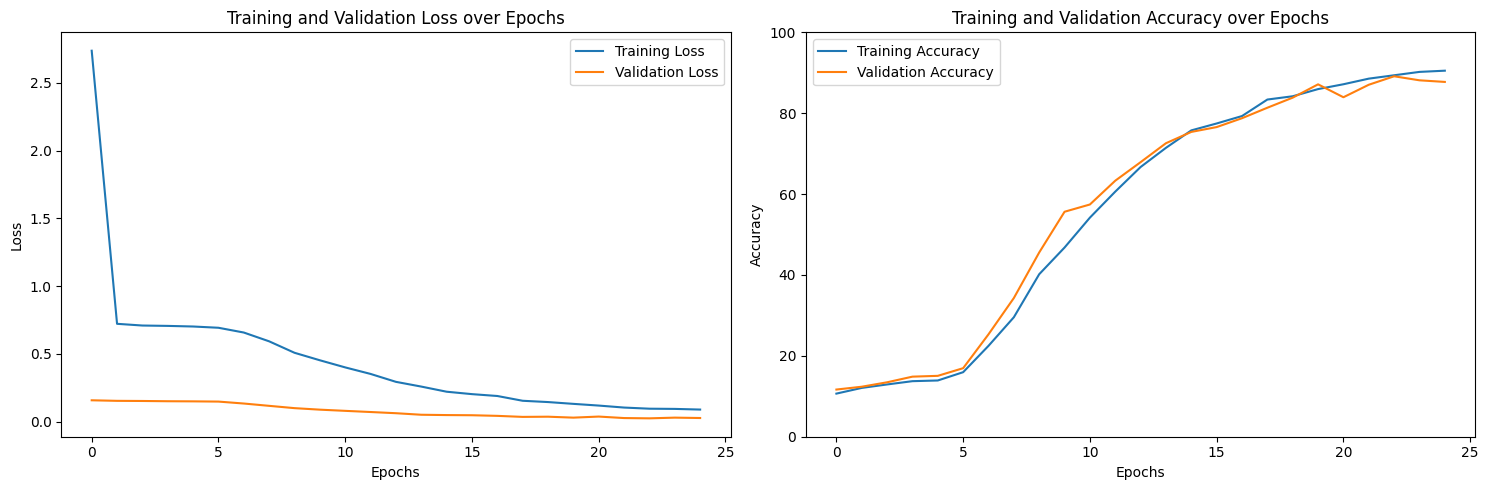

In [32]:
# @title 15. Plotting Training Progress
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()